In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import numpy.linalg as linalg
from multipledispatch import dispatch
import time

import cProfile
from matplotlib.colors import LightSource
import timeit

#scipy sims

In [3]:
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
class Triangle:
    #p_3 is the "tip" i.e. point in the middle of element, p_1 and p_2 are the other two verticies. doesnt matter which order
    def __init__(self, p_1, p_2, p_3):
        self.p1=p_1
        self.p2=p_2
        self.p3=p_3
        
    '''area of this triangle'''
    def area(self):
        return 0.5*np.abs((self.p1.x*self.p2.y+self.p3.x*self.p1.y+self.p2.x*self.p3.y-self.p1.y*self.p2.x-self.p2.y*self.p3.x-self.p3.y*self.p1.x))
    
    '''finds the area given the point p3 as the new vertex'''
    def area_pt(self,p3):
        return 0.5*np.abs((self.p1.x*self.p2.y+p3.x*self.p1.y+self.p2.x*p3.y-self.p1.y*self.p2.x-self.p2.y*p3.x-p3.y*self.p1.x))
    
    '''defines if the point x y is in the triangle. if not then returns false otherwise true'''
    '''source: https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle'''
    def is_in(self,x, y):
        p2y=self.p2.y
        p2x=self.p2.x
        p3x=self.p3.x
        p3y=self.p3.y
        p1x=self.p1.x
        p1y=self.p1.y
        Area= 0.5 *(-self.p2.y*x + self.p1.y*(-self.p2.x + self.p3.x) + self.p1.x*(self.p2.y - self.p3.y) + self.p2.x*self.p3.y)
        s = 1/(2*Area)*(self.p1.y*self.p3.x - self.p1.x*self.p3.y + (self.p3.y - self.p1.y)*x + (self.p1.x - self.p3.x)*y);
        t = 1/(2*Area)*(self.p1.x*self.p2.y - self.p1.y*self.p2.x + (self.p1.y - self.p2.y)*x + (self.p2.x - self.p1.x)*y);
        return 0<=s and t>=0 and 1-s-t>=0
    
    def evaluate(self,x, y):
        return self.area_pt(Point(x, y))/self.area() if self.is_in(x, y) else 0
    
    
class FiniteElement:
    #top left corner
    def __init__(self, x, y, deltaX, deltaY):
        self.deltaX=deltaX
        self.deltaY=deltaY
        
        p1=Point(x, y)
        p2=Point(x+deltaX, y)
        p3=Point(x+2*deltaX, y)
        
        p4=Point(x, y-deltaY)
        center=Point(x+deltaX, y-deltaY)
        p5=Point(x+2*deltaX, y-deltaY)
        
        p6=Point(x, y-2*deltaY)
        p7=Point(x+deltaX, y-2*deltaY)
        p8=Point(x+2*deltaX, y-2*deltaY)
        
        #top left
        self.tri_tl=Triangle(p2,p4,center)
        
        #top right
        self.tri_tr=Triangle(p2,p5,center)
        
        #bottom left
        self.tri_bl=Triangle(p4, p7, center)
        
        #bottom right
        self.tri_br=Triangle(p5,p7,center)
        
        self.top_left_x=x
        self.top_left_y=y
        
    def in_region_1(self, x, y):
        return x<self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_2(self,x, y):
        return x>=self.top_left_x+self.deltaX and y>=self.top_left_y-self.deltaY
    
    def in_region_3(self,x, y):
        return x<self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def in_region_4(self,x, y):
        return x>=self.top_left_x+self.deltaX and y<self.top_left_y-self.deltaY
    
    def evaluate(self, x, y):
        temp=self.tri_tl.evaluate(x, y)
        temp1=self.tri_tr.evaluate(x, y)
        temp2=self.tri_bl.evaluate(x, y)
        temp3=self.tri_br.evaluate(x, y)
        return temp+temp1+temp2+temp3
    
class FEM:
    def __init__(self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition):
        self.N=N
        self.M=M
        self.minX=minX
        self.maxX=maxX
        self.minY=minY
        self.maxY=maxY
        self.deltaX=(maxX-minX)/N
        self.deltaY=(maxY-minY)/M
        #function
        self.electronDensity=electronDensity
        self.finiteElements=self.generateFiniteElements();
        self.eps=eps
        self.boundaryCondition=boundaryCondition
        
        #does not generate the boundary finite elements!
    def generateFiniteElements(self):
        finiteElements=np.ndarray(shape=(self.M-1,self.N-1), dtype=FiniteElement)
        for m in range(self.M-1):
            #ignore the last row
            for n in range(self.N-1):
                finiteElements[m, n]=FiniteElement(self.minX+n*self.deltaX, self.maxY-m*self.deltaY, self.deltaX, self.deltaY)
        return finiteElements
    
    #p1 gives the indicies
    def integrand(self,x, y, p1):
        return (1/self.eps)*self.electronDensity(x,y)*self.finiteElements[p1.x, p1.y].evaluate(x, y)

    def getIntegral(self,p1):
        temp=self.finiteElements[p1.x, p1.y]
        minX=temp.top_left_x
        maxX=minX+self.deltaX*2
        maxY=temp.top_left_y
        minY=maxY-2*self.deltaY
        return integrate.dblquad(self.integrand, minY, maxY, lambda x: minX, lambda x: maxX, args=[p1])[0]

    def constructBVector(self):
        temp=np.zeros((self.N-1)*(self.M-1))
        for r in range(self.M-1):
            for c in range(self.N-1):
                temp[c+r*c]=self.getIntegral(Point(r,c))
                print(c+r*c)
        return temp;
                
    def area(self):
        return self.deltaX*self.deltaY/2
    
    def generateFlagged(self):
        flaggedIndicies1=np.array([self.get1DIndex(0,x) for x in range(self.N+1)]);
        flaggedIndicies2=np.array([self.get1DIndex(y,0) for y in range(self.M+1)]);
        flaggedIndicies3=np.array([self.get1DIndex(self.M,x) for x in range(self.N+1)])
        flaggedIndicies4=np.array([self.get1DIndex(y,self.N) for y in range(self.M+1)]);
        flagged=np.concatenate((flaggedIndicies1,flaggedIndicies2,flaggedIndicies3,flaggedIndicies4))
        return flagged
    
    def constructMatrix(self):
        temp=np.zeros(((self.N+1)*(self.M+1),(self.N+1)*(self.M+1)));
        flagged=self.generateFlagged()
        for m in range(self.M+1):
            for n in range(self.N+1):
                currRow=m*(self.N+1)+n
                index1=self.get1DIndex(m, n-1);
                index2=self.get1DIndex(n,m+1)
                index3=self.get1DIndex(n+1,m)
                index4=self.get1DIndex(n,m-1)
                index5=self.get1DIndex(n, m)
                #print("row, ", currRow)
                if(index1 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index1]=2*(-1/(self.deltaX)**2+1/self.deltaY**2)
                if(index2 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index2]=2*(1/(self.deltaX)**2-1/self.deltaY**2)
                if(index3 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index3]=2*(-1/(self.deltaX)**2+1/self.deltaY**2)
                if(index4 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index4]=2*(1/(self.deltaX)**2-1/self.deltaY**2)
                if(index5 in range((self.N+1)*(self.M+1))):
                    temp[currRow,index5]=4*(1/(self.deltaX)**2+1/self.deltaY**2)
        temp=np.delete(temp, flagged, axis=1)
        temp=np.delete(temp, flagged, axis=0)
        return temp*self.deltaX*self.deltaY/2

    def solveSystem(self):
        b=self.constructBVector();
        M=self.constructMatrix();
        sols=linalg.solve(M, b);
        return self.extractSols(sols);
                
    def getPoint(self,m, n):
        return Point(self.minX+n*self.deltaX, self.minY-m*self.deltaY)
    
    #from 2d to 1d
    def get1DIndex(self,m, n):
        return (self.N+1)*m+n
    
    #in entire matrix
    def get2Dindex(self,i):
        return (i//(self.N+1), i%(self.N+1));
                
    def fillBoundary(self,temp):
        for i in range(np.shape(temp)[0]):
            pt=self.getPoint(i,0)
            pt1=self.getPoint(i, np.shape(temp)[1]-1)
            temp[i,0]=self.boundaryCondition(pt.x, pt.y)
            temp[i,np.shape(temp)[1]-1]=self.boundaryCondition(pt1.x, pt1.y)
        for i in range(np.shape(temp)[1]):
            pt=self.getPoint(0,i)
            pt1=self.getPoint(np.shape(temp)[1]-1, i)
            temp[0,i]=self.boundaryCondition(pt.x, pt.y)
            temp[np.shape(temp)[1]-1, i]=self.boundaryCondition(pt1.x, pt1.y)
        return temp
    
    def extractSols(self,sols):
        temp=np.zeros((self.M+1, self.N+1));
        for i in range(len(sols)):
            row=i//(self.N-1)+1
            col=i%(self.M-1)+1
            temp[row, col]=sols[i]
        temp=self.fillBoundary(temp);
        return temp;
    
    def graphResults(self):
        pass
    
class Test:
    def __init__(self):
        pass
    
    @staticmethod
    def plot(startX, endX, startY, endY,num, func):
        xs = np.linspace(startX, endX,num=num,axis=0)
        ys = np.linspace(startY, endY,num=num,axis=0)

        output=np.array([[x, y] for x in xs for y in ys])
        function=np.array([func(p[0], p[1]) for p in output])

        fig = plt.figure()
        ax = plt.axes(projection='3d')

        function.shape = (function.size//len(xs), len(xs))

        ls = LightSource(azdeg=0, altdeg=65)
        rgb = ls.shade(function, plt.cm.RdYlBu)

        function.shape=(len(xs)*len(ys),)

        new_img = rgb.transpose((2, 0, 1))
        # Dimensions: [3, m, n]
        new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])

        # Create the SCATTER() plot 
        ax.scatter(output[:,0],output[:,1],function, facecolors=new_img);

In [4]:
eps=1

minX=-1
maxX=1
minY=-1
maxY=1

N=10
M=10
sigma=1


def boundaryCondition(x, y):
    return 0

def electronDensity(x, y):
    return (1/np.sqrt(2*np.pi*sigma**2))**3*(np.exp((-(x**2+y**2))/(2*sigma**2)))

#self, N, M, minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition
finiteElement=FEM(N, M,minX, maxX, minY, maxY, electronDensity, eps, boundaryCondition)

In [12]:
cProfile.run('finiteElement.getIntegral(Point(5, 5))')

         5238044 function calls (5229728 primitive calls) in 7.099 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   428799    1.234    0.000    1.234    0.000 1226877424.py:16(electronDensity)
   428799    0.453    0.000    6.846    0.000 880219933.py:111(integrand)
        1    0.000    0.000    7.099    7.099 880219933.py:114(getIntegral)
     2079    0.000    0.000    0.000    0.000 880219933.py:120(<lambda>)
   164040    0.243    0.000    0.243    0.000 880219933.py:14(area)
   164040    0.258    0.000    0.258    0.000 880219933.py:18(area_pt)
   164041    0.042    0.000    0.042    0.000 880219933.py:2(__init__)
  1715196    3.540    0.000    3.540    0.000 880219933.py:23(is_in)
  1715196    0.594    0.000    4.676    0.000 880219933.py:29(evaluate)
   428799    0.483    0.000    5.159    0.000 880219933.py:78(evaluate)
        1    0.000    0.000    7.099    7.099 <string>:1(<module>)
   2080/1    0.002    0.000  

In [520]:
topLeftY=[y.top_left_y for x in finiteElement.finiteElements]

NameError: name 'y' is not defined

In [535]:
topLeftX=[y.top_left_x for finiteElementList in finiteElement.finiteElements for y in finiteElementList]
topLeftY=[y.top_left_y for finiteElementList in finiteElement.finiteElements for y in finiteElementList]

In [536]:
topLeftX

[-1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,
 -1.0,
 -0.8,
 -0.6,
 -0.3999999999999999,
 -0.19999999999999996,
 0.0,
 0.20000000000000018,
 0.40000000000000013,
 0.6000000000000001,
 0.8,

In [537]:
topLeftY

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.3999999999999999,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.20000000000000018,
 -0.40000000000000013,
 -0.40000000000000013,
 -0.40000000000000013,
 -0.40000000000000013,
 -0.4000

In [407]:
#x, y, deltaX, deltaY
#self, x, y, deltaX, deltaY
M=finiteElement.constructMatrix()
b=finiteElement.constructBVector()

In [408]:
M[0]

array([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [409]:
b

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [410]:
finiteElement.solveSystem()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [411]:
np.shape(b)

(81,)

In [280]:
def plot(startX, endX, startY, endY,num):
    xs = np.linspace(startX, endX,num=num,axis=0)
    ys = np.linspace(startY, endY,num=num,axis=0)

    output=np.array([[x, y] for x in xs for y in ys])
    function=[fin.evaluate(p[0], p[1]) for p in output]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    # Create the SCATTER() plot 
    ax.scatter(output[:,0],output[:,1],function);

    ax.scatter(0,-1,0,c="orange")
    ax.scatter(1,-1,1,c="orange")
    ax.scatter(1,0,0,c="orange")

In [112]:
print(fin.tri_tl.p1.x,", ",fin.tri_tl.p1.y)
print(fin.tri_tl.p2.x,", ",fin.tri_tl.p2.y)
print(fin.tri_tl.p3.x,", ",fin.tri_tl.p3.y)

1 ,  0
0 ,  -1
1 ,  -1


In [254]:
fin.tri_br.evaluate(1,-1)

ugh


0

In [255]:
fin.evaluate(1,-0.5)

ugh


0

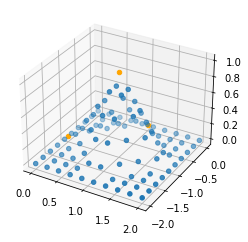

In [218]:
print(fin.tri_tr.area())

0.0


In [260]:
print(fin.tri_br.p1.x,fin.tri_br.p1.y)
print(fin.tri_br.p2.x,fin.tri_br.p2.y)
print(fin.tri_br.p3.x,fin.tri_br.p3.y)

2 -1
1 -2
1 -1


In [265]:
fin.tri_br.is_in(0.5,-0.5)

s 0.5
t -2.0


False

In [266]:
fin.tri_tl.is_in(0.5,-0.5)

s 0.5
t 0.0


True

In [237]:
print(fin.tri_br.area())

0.5


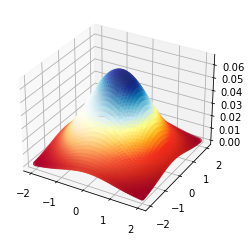

In [469]:
Test.plot(-2, 2, -2, 2, 50, electronDensity)

In [7]:
Test.plot(0,2,-2,0,50,fin.evaluate)

NameError: name 'fin' is not defined

In [451]:
rgb

array([[[0.68481796, 0.        , 0.16496235, 1.        ],
        [0.75905341, 0.05379805, 0.18212881, 1.        ],
        [0.84628762, 0.14192815, 0.20761217, 1.        ],
        [0.92329873, 0.27363132, 0.23586449, 1.        ],
        [0.95482765, 0.39779499, 0.29295771, 1.        ],
        [0.95482765, 0.39779499, 0.29295771, 1.        ],
        [0.92329873, 0.27363132, 0.23586449, 1.        ],
        [0.84628762, 0.14192815, 0.20761217, 1.        ],
        [0.75905341, 0.05379805, 0.18212881, 1.        ],
        [0.68481796, 0.        , 0.16496235, 1.        ]],

       [[0.73246635, 0.04995992, 0.16913513, 1.        ],
        [0.84716872, 0.17687766, 0.19161746, 1.        ],
        [0.94752375, 0.45880295, 0.30754923, 1.        ],
        [0.98984129, 0.84021039, 0.50778829, 1.        ],
        [0.9978578 , 0.93506363, 0.66781057, 1.        ],
        [0.9978578 , 0.93506363, 0.66781057, 1.        ],
        [0.98984129, 0.84021039, 0.50778829, 1.        ],
        [0.9

In [447]:
rgb.shape

(10, 10, 4)

In [457]:
new_img = rgb.transpose((2, 0, 1))
# Dimensions: [3, m, n]
new_img = rgb.reshape(rgb.shape[0]*rgb.shape[1], rgb.shape[2])


In [458]:
new_img

array([[0.68481796, 0.        , 0.16496235, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.95482765, 0.39779499, 0.29295771, 1.        ],
       [0.92329873, 0.27363132, 0.23586449, 1.        ],
       [0.84628762, 0.14192815, 0.20761217, 1.        ],
       [0.75905341, 0.05379805, 0.18212881, 1.        ],
       [0.68481796, 0.        , 0.16496235, 1.        ],
       [0.73246635, 0.04995992, 0.16913513, 1.        ],
       [0.84716872, 0.17687766, 0.19161746, 1.        ],
       [0.94752375, 0.45880295, 0.30754923, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.9978578 , 0.93506363, 0.66781057, 1.        ],
       [0.98984129, 0.84021039, 0.50778829, 1.        ],
       [0.94752375, 0.45880295,

In [10]:
fin=FiniteElement(0, 0, 1, 1)

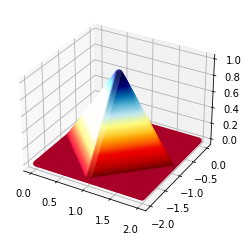

In [11]:
Test.plot(0, 2, -2, 0,100,fin.evaluate)

In [579]:
integrate.dblquad(fin.evaluate, -2, 0,lambda x: 0, lambda x: 2)[0]

0.6666666499049005

In [573]:
fin.evaluate(1.8,-1.8)

0

In [607]:
integrate.dblquad(electronDensity, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8)[0]

0.090866060540632

In [ ]:
Test.plot(0, 0.4, -0.4, 0,100,finiteElement.finiteElements[5, 5].evaluate)
Test.plot(0, 0.4, -0.4, 0,100,electronDensity)

In [13]:
def lol(x, y):
    return electronDensity(x, y)*fin.evaluate(x, y)

In [636]:
test=[(integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-8*10**i)[0]) for i in range(0, 7)]

In [637]:
test

[0.0016191353028300304,
 0.0016191286222514505,
 0.0016191289772780834,
 0.00161919315870105,
 0.0016219522329523855,
 0.001613626045322107,
 0.0015999807360674192]

In [640]:
1e-8*10**4

0.0001

In [16]:
cProfile.run('integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2)[0]')

         473690 function calls (473438 primitive calls) in 0.759 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    38073    0.123    0.000    0.123    0.000 1226877424.py:16(electronDensity)
    38073    0.030    0.000    0.732    0.000 2234026894.py:1(lol)
    17993    0.079    0.000    0.079    0.000 880219933.py:14(area)
    17993    0.032    0.000    0.032    0.000 880219933.py:18(area_pt)
    17993    0.005    0.000    0.005    0.000 880219933.py:2(__init__)
   152292    0.351    0.000    0.351    0.000 880219933.py:23(is_in)
   152292    0.063    0.000    0.530    0.000 880219933.py:29(evaluate)
    38073    0.049    0.000    0.579    0.000 880219933.py:78(evaluate)
       63    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.758    0.758 <string>:1(<module>)
     64/1    0.000    0.000    0.758    0.758 quadpack.py:445(_quad)
     64/1    0.000    0.000    0.758    0.758 quadp

In [622]:
integrate.dblquad(lol, -2, 0,lambda x: 0, lambda x: 2,epsabs=1e-4)[0]

0.0016219522329523855

In [623]:
1e-8+1e-1

0.10000001

In [634]:
1e-8*6*10

6.000000000000001e-07